# IST597:- Multi-Layer Perceptron

## Load the libraries

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
import tensorflow_datasets
from tqdm import tqdm
import pickle
from tensorflow.keras.layers import Dense, Flatten, Conv2D



In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [82]:
# Hyper parameter Setting
size_input = 784
size_hidden = 256
size_output = 10
NUM_EPOCHS = 20
dropout = False
l1 = 0.1
l2 = 0.1
lr = 0.001
dataset = "fashion_mnist"
# dataset = "mnist"
regularizer = "L1L2"
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
np.random.seed(8888)
tf.random.set_seed(8888)

In [83]:
# load data from keras
def load_data(dataset, batch_size=20):
  if dataset == "mnist":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  elif dataset == "fashion_mnist":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0
  # Split dataset into batches
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
  test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

  return [train_ds, test_ds]

  

## Build MLP

In [84]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.b1, self.b2]



## Train Model

In [85]:
result = []
[train_ds, test_ds] = load_data(dataset)
with tf.device('gpu:0'):
  mlp_on_cpu = MLP(size_input, size_hidden, size_output)
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


  time_start = time.time()
  for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
    # print(len(train_ds))
    for images, labels in tqdm(train_ds):
      with tf.GradientTape() as tape:
        # Cast X to float32
        X = images
        layer = tf.keras.layers.Dropout(.2)
        X_tf = tf.cast(X, dtype=tf.float32)
        X_tf = tf.reshape(X_tf, [20,784])
        #Remember to normalize your dataset before moving forward
        # Compute values in hidden layer
        what = tf.matmul(X_tf, mlp_on_cpu.W1) + mlp_on_cpu.b1
        hhat = tf.nn.relu(what)
        if dropout:
          output = layer(tf.matmul(hhat, mlp_on_cpu.W2) + mlp_on_cpu.b2)
        else:
          output = tf.matmul(hhat, mlp_on_cpu.W2) + mlp_on_cpu.b2 
          
        if regularizer == "L1L2":
          loss = loss_object(labels, output)- l1 * tf.math.reduce_sum(abs(X_tf)) - l2 * tf.math.reduce_sum(tf.math.square(X_tf))
        else:
          loss = loss_object(labels, output)
      gradients = tape.gradient(loss, mlp_on_cpu.variables)
      optimizer.apply_gradients(zip(gradients, mlp_on_cpu.variables))
      train_loss(loss)
      train_accuracy(labels, output)
    print('Number of Epoch = {} - Average Loss:= {} - Average Accuracy:= {}'.format(epoch + 1, train_loss.result().numpy(), train_accuracy.result().numpy()))
    result.append([epoch + 1, train_loss.result().numpy(), train_accuracy.result().numpy()])
  time_taken = time.time() - time_start
  filename = '{}-{}-{}-{}-{}-{}'.format(dropout, lr, dataset,regularizer, l1, l2)
  outfile = open(filename,'wb')
  pickle.dump([result, time_taken], outfile)
  outfile.close()
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Epoch:  0


100%|██████████| 3000/3000 [00:34<00:00, 85.90it/s]


Number of Epoch = 1 - Average Loss:= -761.766845703125 - Average Accuracy:= 0.7388666868209839
Epoch:  1


100%|██████████| 3000/3000 [00:31<00:00, 95.59it/s]


Number of Epoch = 2 - Average Loss:= -764.6197509765625 - Average Accuracy:= 0.7711416482925415
Epoch:  2


100%|██████████| 3000/3000 [00:32<00:00, 92.40it/s]


Number of Epoch = 3 - Average Loss:= -766.0029296875 - Average Accuracy:= 0.787850022315979
Epoch:  3


100%|██████████| 3000/3000 [00:32<00:00, 93.38it/s] 


Number of Epoch = 4 - Average Loss:= -766.881591796875 - Average Accuracy:= 0.7996249794960022
Epoch:  4


100%|██████████| 3000/3000 [00:31<00:00, 95.41it/s]


Number of Epoch = 5 - Average Loss:= -767.5076904296875 - Average Accuracy:= 0.8088499903678894
Epoch:  5


100%|██████████| 3000/3000 [00:31<00:00, 95.92it/s]


Number of Epoch = 6 - Average Loss:= -767.9867553710938 - Average Accuracy:= 0.8164111375808716
Epoch:  6


100%|██████████| 3000/3000 [00:30<00:00, 96.79it/s]


Number of Epoch = 7 - Average Loss:= -768.3683471679688 - Average Accuracy:= 0.8228928446769714
Epoch:  7


100%|██████████| 3000/3000 [00:31<00:00, 95.56it/s]


Number of Epoch = 8 - Average Loss:= -768.6846923828125 - Average Accuracy:= 0.8286041617393494
Epoch:  8


100%|██████████| 3000/3000 [00:31<00:00, 96.35it/s]


Number of Epoch = 9 - Average Loss:= -768.9495849609375 - Average Accuracy:= 0.8335444331169128
Epoch:  9


100%|██████████| 3000/3000 [00:41<00:00, 73.09it/s]


Number of Epoch = 10 - Average Loss:= -769.1743774414062 - Average Accuracy:= 0.8380699753761292
Epoch:  10


100%|██████████| 3000/3000 [00:31<00:00, 96.37it/s]


Number of Epoch = 11 - Average Loss:= -769.3710327148438 - Average Accuracy:= 0.8422242403030396
Epoch:  11


100%|██████████| 3000/3000 [00:31<00:00, 95.13it/s]


Number of Epoch = 12 - Average Loss:= -769.5438232421875 - Average Accuracy:= 0.846095860004425
Epoch:  12


100%|██████████| 3000/3000 [00:32<00:00, 92.52it/s]


Number of Epoch = 13 - Average Loss:= -769.69677734375 - Average Accuracy:= 0.8496551513671875
Epoch:  13


100%|██████████| 3000/3000 [00:41<00:00, 73.10it/s]


Number of Epoch = 14 - Average Loss:= -769.8325805664062 - Average Accuracy:= 0.852990448474884
Epoch:  14


100%|██████████| 3000/3000 [00:48<00:00, 61.31it/s]


Number of Epoch = 15 - Average Loss:= -769.9542846679688 - Average Accuracy:= 0.856166660785675
Epoch:  15


100%|██████████| 3000/3000 [01:21<00:00, 36.59it/s]


Number of Epoch = 16 - Average Loss:= -770.0634155273438 - Average Accuracy:= 0.8590999841690063
Epoch:  16


100%|██████████| 3000/3000 [00:50<00:00, 59.28it/s]


Number of Epoch = 17 - Average Loss:= -770.1614990234375 - Average Accuracy:= 0.8618245124816895
Epoch:  17


100%|██████████| 3000/3000 [01:22<00:00, 36.57it/s]


Number of Epoch = 18 - Average Loss:= -770.2503051757812 - Average Accuracy:= 0.8643962740898132
Epoch:  18


100%|██████████| 3000/3000 [00:41<00:00, 73.11it/s]


Number of Epoch = 19 - Average Loss:= -770.3305053710938 - Average Accuracy:= 0.8669579029083252
Epoch:  19


100%|██████████| 3000/3000 [00:31<00:00, 95.43it/s]

Number of Epoch = 20 - Average Loss:= -770.4050903320312 - Average Accuracy:= 0.8692799806594849

Total time taken (in seconds): 800.64


## Test

In [86]:
# Test on Testset 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
test_loss_total = tf.Variable(0, dtype=tf.float32)
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
#test_loss_total = 0.0
for images, labels in tqdm(test_ds):
  with tf.GradientTape() as tape:
    # Cast X to float32
    X = images
    layer = tf.keras.layers.Dropout(.2)
    X_tf = tf.cast(X, dtype=tf.float32)
    X_tf = tf.reshape(X_tf, [20,784])
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, mlp_on_cpu.W1) + mlp_on_cpu.b1
    hhat = tf.nn.relu(what)
    if dropout:
      output = layer(tf.matmul(hhat, mlp_on_cpu.W2) + mlp_on_cpu.b2)
    else:
      output = tf.matmul(hhat, mlp_on_cpu.W2) + mlp_on_cpu.b2 
      
    if regularizer == "L1L2":
      loss = loss_object(labels, output)- l1 * tf.math.reduce_sum(abs(X_tf)) - l2 * tf.math.reduce_sum(tf.math.square(X_tf))
    else:
      loss = loss_object(labels, output)
    test_loss(loss)
    test_accuracy(labels, output)
print('Test Result - Average Loss:= {} - Average Accuracy:= {}'.format(test_loss.result().numpy(), test_accuracy.result().numpy()))

100%|██████████| 500/500 [00:03<00:00, 148.30it/s]

Test Result - Average Loss:= -771.993896484375 - Average Accuracy:= 0.8416000008583069


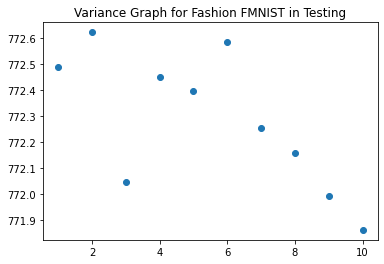

In [89]:
# do Plotting
import matplotlib.pyplot as plt
infile = open("/content/False-0.001-fashion_mnist-L1L2-0.1-0.1",'rb')
new_dict = pickle.load(infile)
infile.close()
x=[]
y_loss=[]
z_acc=[]
print(new_dict[1])
for i in new_dict[0]:
  x.append(i[0])
  y_loss.append(i[1])
  z_acc.append(i[2])
plt.plot(x, y_loss, label = "Epoch vs Loss")
# plt.plot(x, z_acc, label = "Epoch vs Acc")

plt.xlabel('x - Epoch')
# plt.ylabel('y - Acc')
plt.ylabel('y - Loss')
plt.title('Loss Graph for Fashion FMNIST')
# plt.title('Acc Graph for Fashion FMNIST')
plt.show()


# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_variance = [770.383, 770.677, 770.214, 770.437, 770.368, 770.570, 770.313, 770.374, 770.405, 770.517]
# test_variance = [772.490, 772.624, 772.049, 772.451, 772.399, 772.587, 772.256, 772.161, 771.993, 771.863]
# plt.scatter(x, test_variance, label = "Test_Variance")
# plt.title('Variance Graph for Fashion FMNIST in Testing')
# plt.show()
